In [1]:
import pathlib
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns

## (optional) remove gridlines from plots
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

In [2]:
## To-do: update path to WHOI file server on your machine
## On Mac, the default location is "/Volumes"
server_path = pathlib.Path("/Volumes")

In [3]:
## path to the data (from the root of the server)
t2m_path_on_server = pathlib.Path(
    "cmip6/data/era5/reanalysis/single-levels/monthly-means/2m_temperature"
)

## combine these into single path
t2m_path = pathlib.Path(server_path, t2m_path_on_server)

## Get list of files and print out the first 5
t2m_files = list(t2m_path.glob("*.nc"))
for f in t2m_files[:5]:
    print(f)

/Volumes/cmip6/data/era5/reanalysis/single-levels/monthly-means/2m_temperature/1979_2m_temperature.nc
/Volumes/cmip6/data/era5/reanalysis/single-levels/monthly-means/2m_temperature/1980_2m_temperature.nc
/Volumes/cmip6/data/era5/reanalysis/single-levels/monthly-means/2m_temperature/1981_2m_temperature.nc
/Volumes/cmip6/data/era5/reanalysis/single-levels/monthly-means/2m_temperature/1982_2m_temperature.nc
/Volumes/cmip6/data/era5/reanalysis/single-levels/monthly-means/2m_temperature/1983_2m_temperature.nc


In [4]:
t2m = xr.open_mfdataset(t2m_files)["t2m"]

In [5]:
def plot_setup(fig, projection, lon_range, lat_range):
    """Add a subplot to the figure with the given map projection
    and lon/lat range. Returns an Axes object."""

    ## Create subplot with given projection
    ax = fig.add_subplot(projection=projection)

    ## Subset to given region
    extent = [*lon_range, *lat_range]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ## draw coastlines
    ax.coastlines()

    return ax


def plot_setup_pacific(fig):
    """Plot Pacific region"""

    ## set map projection to orthographic
    proj = ccrs.Orthographic(central_longitude=180, central_latitude=50)

    return plot_setup(fig, proj, lon_range=[120, 240], lat_range=[30, 70])


def plot_setup_atlantic(fig):
    """Plot Pacific region"""

    ## set map projection to orthographic
    proj = ccrs.Orthographic(central_longitude=-50, central_latitude=40)

    return plot_setup(fig, proj, lon_range=[-100, 0], lat_range=[10, 70])

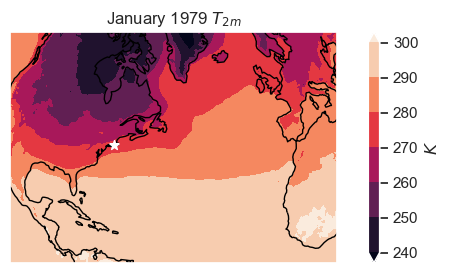

In [6]:
## blank canvas to plot on
fig = plt.figure(figsize=(8, 3))

## draw background map of Pacific
# ax = plot_setup_pacific(fig)
ax = plot_setup_atlantic(fig)

## plot the first timestep of 2m-temperature
plot_data = ax.contourf(
    t2m.longitude,
    t2m.latitude,
    t2m.isel(time=0),
    transform=ccrs.PlateCarree(),
    levels=np.arange(240, 310, 10),
    extend="both",
)

## create colorbath
colorbar = fig.colorbar(plot_data, label=r"$K$")

## Mark Woods Hole on map
ax.scatter(
    288.5, 41.5, transform=ccrs.PlateCarree(), marker="*", c="w", s=50, zorder=10
)

## label
ax.set_title(r"January 1979 $T_{2m}$")

plt.show()

In [7]:
def get_WH_idx(global_t2m):
    """
    Input: 'global_t2m' is a 3-D DataArray (lon,lat,time)

    Output: 'climate_index' is a 1-D DataArray (time)
    """

    ## Get temperature in grid cell near Woods Hole
    t2m_WH = t2m.sel(latitude=41.5, longitude=288.5)

    ## Remove monthly mean (climatology)
    t2m_WH_clim = t2m_WH.groupby("time.month").mean()
    t2m_WH = t2m_WH.groupby("time.month") - t2m_WH_clim

    return t2m_WH

In [8]:
t2m_WH = get_WH_idx(t2m).compute()

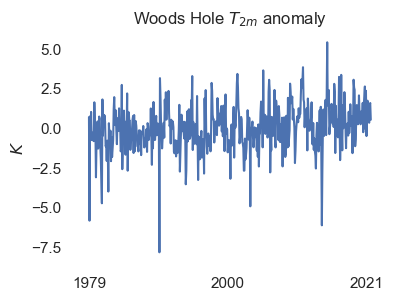

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))

## Plot the data
ax.plot(t2m_WH.time, t2m_WH)

## label axes
ax.set_title(r"Woods Hole $T_{2m}$ anomaly")
ax.set_ylabel(r"$K$")

## label x-axis
ax.set_xticks(
    [datetime.date(1979, 1, 1), datetime.date(2000, 6, 30), datetime.date(2021, 12, 31)]
)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.show()